# Preliminary Analysis of Statement Sentiment by Lexicon
Analyse statement by Loughran and McDonald word list to see if the relationship between economy and net sentiment 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt
import os
import pickle
import codecs
import re
from tqdm import tqdm_notebook as tqdm


#For tokenizing sentences
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/hanyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')

### Reading the data in

In [4]:
# Define the directory path where the .txt files are located.
directory_path = '../data/FOMC/statements.clean'

# Initialize an empty list to store the data.
data = []

# Loop through each file in the directory.
for file_name in os.listdir(directory_path):
    # Check if the file is a .txt file.
    if file_name.endswith('.txt'):
        # Extract the date from the file name.
        date_str = file_name.replace('FOMC_statement_', '').replace('.txt', '')
        date = dt.datetime.strptime(date_str, '%Y-%m-%d')
        
        # Read the content of the file.
        file_path = os.path.join(directory_path, file_name)
        with open(file_path, 'r') as file:
            content = file.read()
        # word_count = len(content.split())
        # Append the date and content to the data list.
        data.append({'date': date, 'content': content})

# Create a DataFrame from the data list.
Data = pd.DataFrame(data)

# Sort the DataFrame by date.
Data = Data.sort_values(by='date').reset_index(drop=True)

# Output the DataFrame to check.
Data.head()


,date,content
0,1994-02-04,chairman alan greenspan announced today fomc d...
1,1994-03-22,chairman alan greenspan announced today fomc d...
2,1994-04-18,chairman alan greenspan announced today federa...
3,1994-05-17,the federalreserve today announced actions des...
4,1994-08-16,the federalreserve announced today following m...


In [5]:
# Data['date'] = pd.to_datetime(Data['year_month'])
# Sort the DataFrame by date.
Data = Data.sort_values(by='date').reset_index(drop=True)

In [6]:
Data

,date,content
0,1994-02-04,chairman alan greenspan announced today fomc d...
1,1994-03-22,chairman alan greenspan announced today fomc d...
2,1994-04-18,chairman alan greenspan announced today federa...
3,1994-05-17,the federalreserve today announced actions des...
4,1994-08-16,the federalreserve announced today following m...
...,...,...
220,2023-05-03,share economic activity expanded modest pace j...
221,2023-06-14,share recent indicators suggest economic activ...
222,2023-07-26,share recent indicators suggest economic activ...
223,2023-09-20,share recent indicators suggest economic activ...


### Creating a Financial Dictionary based on Loughran and McDonald

In [7]:
# Make 'date' column as the index of Data
Data.set_index(['date'], inplace=True)
Data.head()

,content
date,
1994-02-04,chairman alan greenspan announced today fomc d...
1994-03-22,chairman alan greenspan announced today fomc d...
1994-04-18,chairman alan greenspan announced today federa...
1994-05-17,the federalreserve today announced actions des...
1994-08-16,the federalreserve announced today following m...


In [8]:
with open('../data/LoughranMcDonald/sentiment_dictionaries.pkl', 'rb') as file:
    sentiment_dictionaries = pickle.load(file)

lmdict = {'Negative': [x.lower() for x in sentiment_dictionaries['negative'].keys()],
          'Positive': [x.lower() for x in sentiment_dictionaries['positive'].keys()]}
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [9]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [10]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
 
    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
 
    word_count = len(input_words)
 
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    results = [word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

In [11]:
print(len(Data))
temp = [tone_count_with_negation_check(lmdict,x) for x in Data.content]
temp = pd.DataFrame(temp)

Data['wordcount'] = temp.iloc[:,0].values
Data['NPositiveWords'] = temp.iloc[:,1].values
Data['NNegativeWords'] = temp.iloc[:,2].values

#Sentiment Score normalized by the number of words
Data['sentiment'] = (Data['NPositiveWords'] - Data['NNegativeWords']) / Data['wordcount'] * 100

Data['Poswords'] = temp.iloc[:,3].values
Data['Negwords'] = temp.iloc[:,4].values


225


In [12]:
temp.head()

,0,1,2,3,4
0,61,1,1,[enhance],[misunderstanding]
1,31,0,0,[],[]
2,30,0,0,[],[]
3,83,2,0,"[favorable, effective]",[]
4,65,2,0,"[effective, strength]",[]


In [13]:
Data.head()

,content,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords
date,,,,,,,
1994-02-04,chairman alan greenspan announced today fomc d...,61,1,1,0.000000,[enhance],[misunderstanding]
1994-03-22,chairman alan greenspan announced today fomc d...,31,0,0,0.000000,[],[]
1994-04-18,chairman alan greenspan announced today federa...,30,0,0,0.000000,[],[]
1994-05-17,the federalreserve today announced actions des...,83,2,0,2.409639,"[favorable, effective]",[]
1994-08-16,the federalreserve announced today following m...,65,2,0,3.076923,"[effective, strength]",[]


### Plots of the sentiment analysis

Plot positive and negative word counts

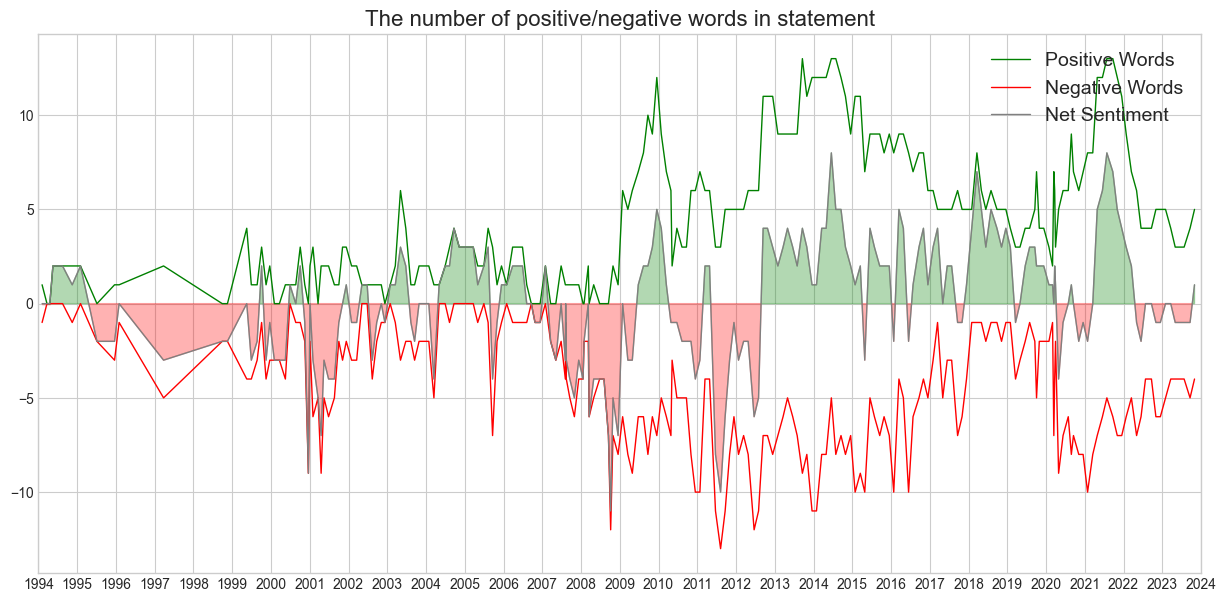

In [14]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

plt.figure(figsize=(15,7))
ax = plt.subplot()

plt.plot(Data.index, Data['NPositiveWords'], c='green', linewidth= 1.0)
plt.plot(Data.index, Data['NNegativeWords']*-1, c='red', linewidth=1.0)
plt.plot(Data.index, NetSentiment, c='grey', linewidth=1.0)

plt.title('The number of positive/negative words in statement', fontsize=16)
plt.legend(['Positive Words', 'Negative Words', 'Net Sentiment'], prop={'size': 14}, loc=1)

ax.fill_between(Data.index, NetSentiment, where=(NetSentiment > 0), color='green', alpha=0.3, interpolate=True)
ax.fill_between(Data.index, NetSentiment, where=(NetSentiment <= 0), color='red', alpha=0.3, interpolate=True)

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

ax.grid(True)

plt.show()

Positive and negative word counts highly correlate... probably because of the total number of words varies. Take the positive - negative as Net Sentiment.

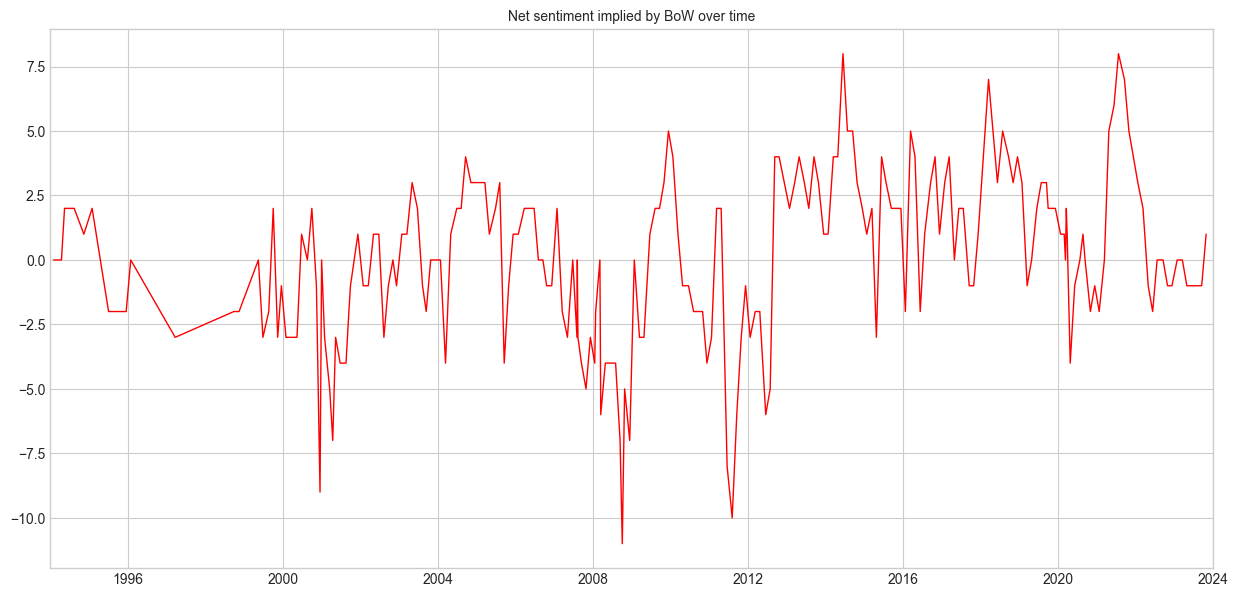

In [15]:
NetSentiment = Data['NPositiveWords'] - Data['NNegativeWords']

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, NetSentiment, 
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

Plot derivative to see the changes in net sentiment

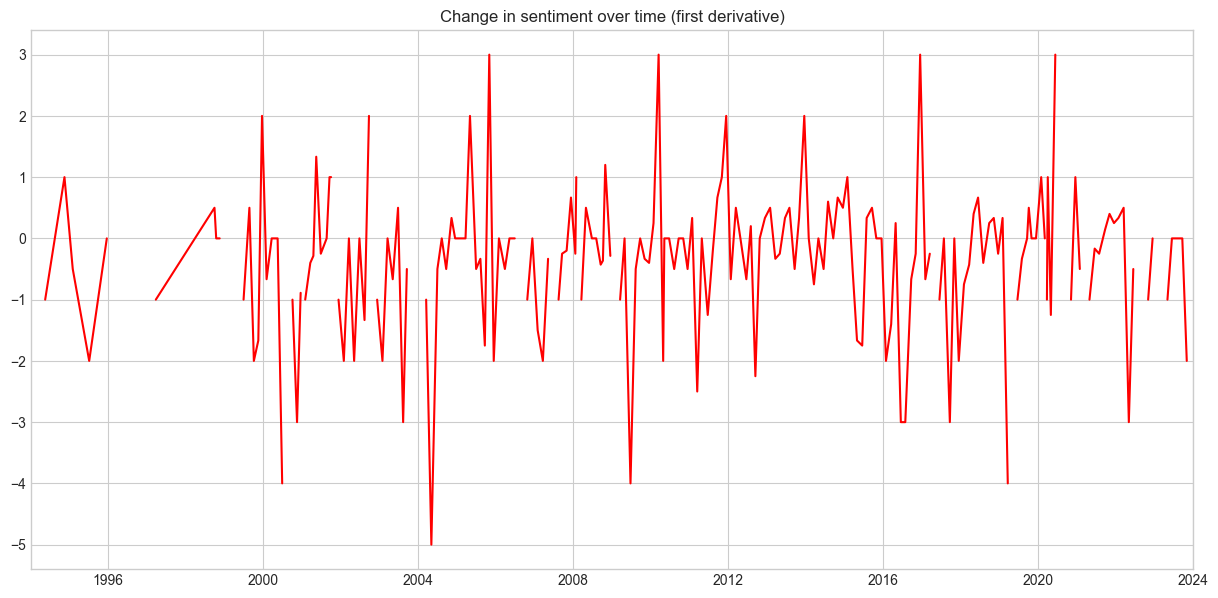

In [16]:
firstderivative = (NetSentiment.shift(1) - NetSentiment) / NetSentiment

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, firstderivative, 
         c = 'red')

plt.title('Change in sentiment over time (first derivative)')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

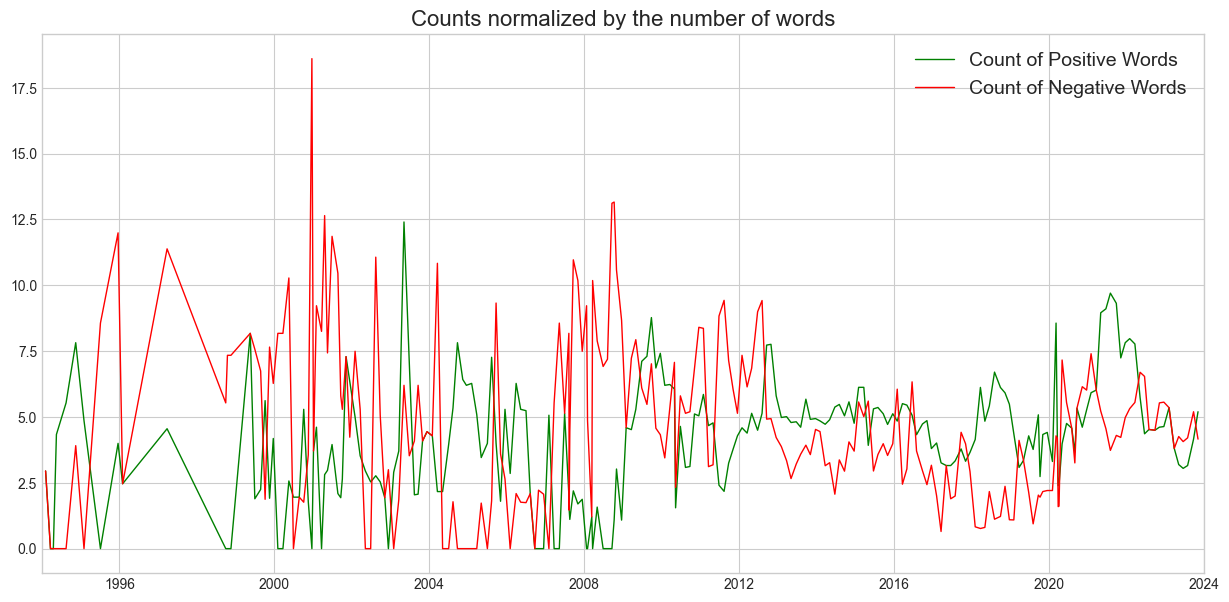

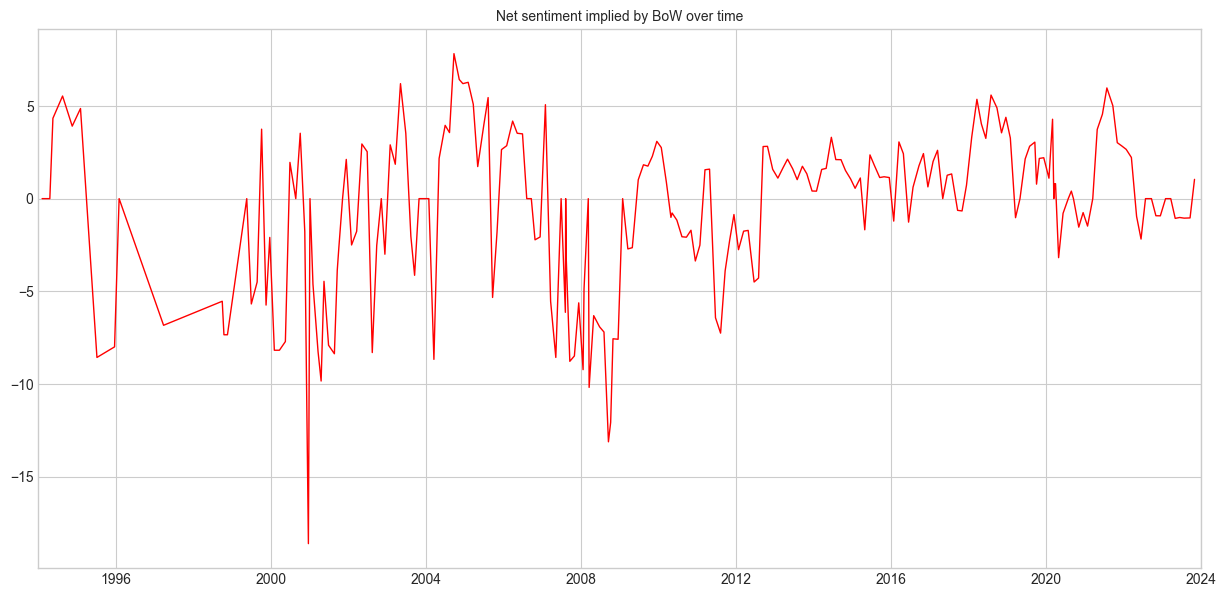

In [17]:
# Normalize data
NPositiveWordsNorm = Data['NPositiveWords'] / Data['wordcount'] * np.mean(Data['wordcount'])
NNegativeWordsNorm = Data['NNegativeWords'] / Data['wordcount'] * np.mean(Data['wordcount'])
NetSentimentNorm = (NPositiveWordsNorm - NNegativeWordsNorm)

fig, ax = plt.subplots(figsize=(15,7))
ax.plot(Data.index, NPositiveWordsNorm, c='green', linewidth= 1.0)
plt.plot(Data.index, NNegativeWordsNorm, c='red', linewidth=1.0)

plt.title('Counts normalized by the number of words', fontsize=16)
plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 14},
           loc = 1
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


fig, ax = plt.subplots(figsize=(15,7))
ax.plot(Data.index, NetSentimentNorm, c='red', linewidth=1.0)

plt.title('Net sentiment implied by BoW over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

Appends decision, dummy and Moves and End Rate Values for Fed and Disc Rate also appends preferred fed rate Move while measuring the speed of the extraction

In [18]:
Data.tail()
#Data.drop(index=[pd.to_datetime("2020-03-03")], inplace=True)

,content,wordcount,NPositiveWords,NNegativeWords,sentiment,Poswords,Negwords
date,,,,,,,
2023-05-03,share economic activity expanded modest pace j...,169,3,4,-0.591716,"[gains, achieve, attainment]","[unemployment, tightening, lags, impede]"
2023-06-14,share recent indicators suggest economic activ...,177,3,4,-0.564972,"[gains, achieve, attainment]","[unemployment, tightening, lags, impede]"
2023-07-26,share recent indicators suggest economic activ...,171,3,4,-0.584795,"[gains, achieve, attainment]","[unemployment, tightening, lags, impede]"
2023-09-20,share recent indicators suggest economic activ...,173,4,5,-0.578035,"[gains, strong, achieve, attainment]","[slowed, unemployment, tightening, lags, impede]"
2023-11-01,share recent indicators suggest economic activ...,173,5,4,0.578035,"[strong, gains, strong, achieve, attainment]","[unemployment, tightening, lags, impede]"


In [21]:
Data.to_csv('../data/preprocessed/statement_LM_sentiment.csv')

In [19]:
fed = pd.read_csv('../data/MarketData/Predicting Fed Rate.csv')
fed = fed[['observation_date','FEDFUNDS']]
fed.columns = ['Date','Rate']
fed.set_index('Date', inplace=True)
fed.index = pd.to_datetime(fed.index)
fed

,Rate
Date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83
...,...
2023-05-01,5.06
2023-06-01,5.08
2023-07-01,5.12


### Plot the results and compare to the economical uncertainty / systemic risk periods

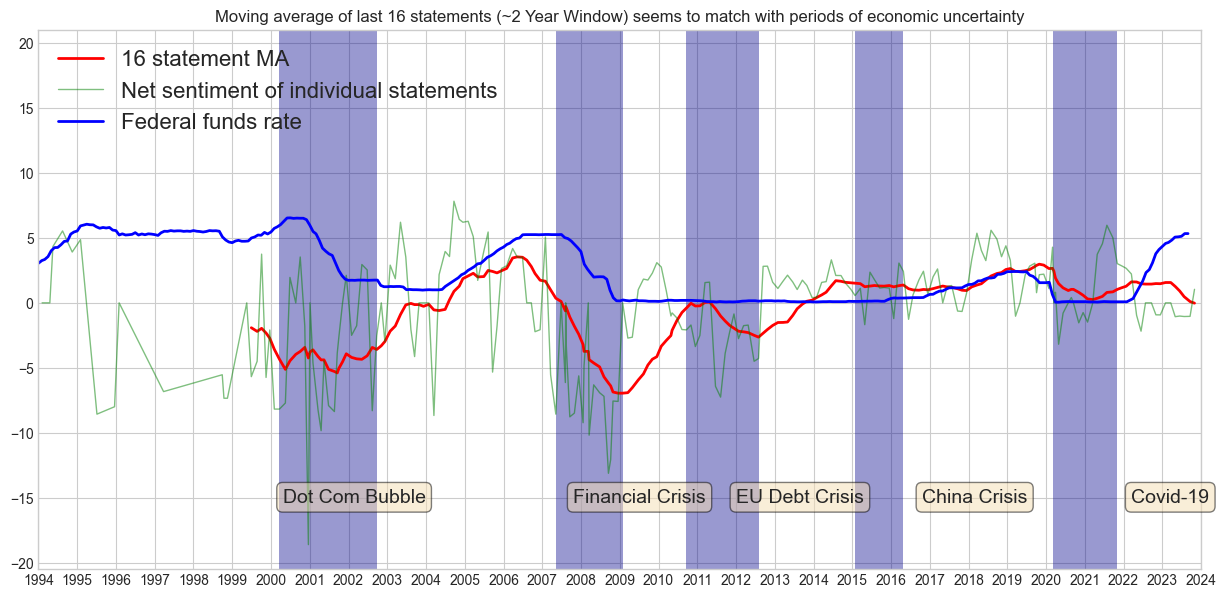

In [20]:
#Dot-com bubble
#https://en.wikipedia.org/wiki/Dot-com_bubble
DotCom = np.logical_and(Data.index > '2000-03', Data.index < '2002-10')

#Financial crisis of 2007–2008
#https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008
FinCrisis = np.logical_and(Data.index > '2007-04', Data.index < '2009-03')

#European debt crisis
#https://en.wikipedia.org/wiki/European_debt_crisis
EuroDebt = np.logical_and(Data.index > '2010-09', Data.index < '2012-09')

#2015–16 Chinese stock market turbulence
#https://en.wikipedia.org/wiki/2015%E2%80%9316_Chinese_stock_market_turbulence
Asian = np.logical_and(Data.index > '2015-01', Data.index < '2016-06')

#2020- Covid-19 Pandemic
#https://en.wikipedia.org/wiki/COVID-19_pandemic
Covid = np.logical_and(Data.index > '2020-02', Data.index < '2021-12')

Recessions = np.logical_or.reduce((DotCom, FinCrisis, EuroDebt, Asian, Covid))

Window = 16
CompToMA = NetSentimentNorm.rolling(Window).mean()

fig, ax = plt.subplots(figsize=(15,7))

ax.plot(Data.index, CompToMA, c = 'r', linewidth= 2)
ax.plot(Data.index, NetSentimentNorm, c = 'green', linewidth= 1, alpha = 0.5)
ax.plot(fed.index, fed, c = 'b', linewidth = 2)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

# round to nearest years.
datemin = np.datetime64(Data.index[0], 'Y')
datemax = np.datetime64(Data.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.title( str('Moving average of last ' + str(Window) + ' statements (~2 Year Window) seems to match with periods of economic uncertainty'))

ax.legend([str(str(Window) + ' statement MA'), 
           'Net sentiment of individual statements',
           'Federal funds rate'],
           prop={'size': 16},
           loc = 2
          )

import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
theta = 0.9
ax.fill_between(Data.index, 0, 10, where = Recessions,
                facecolor='darkblue', alpha=0.4, transform=trans)

# Add text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.21, 0.15, "Dot Com Bubble", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.46, 0.15, "Financial Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.60, 0.15, "EU Debt Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.76, 0.15, "China Crisis", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.text(0.94, 0.15, "Covid-19", transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)

plt.show()

# wordcloud


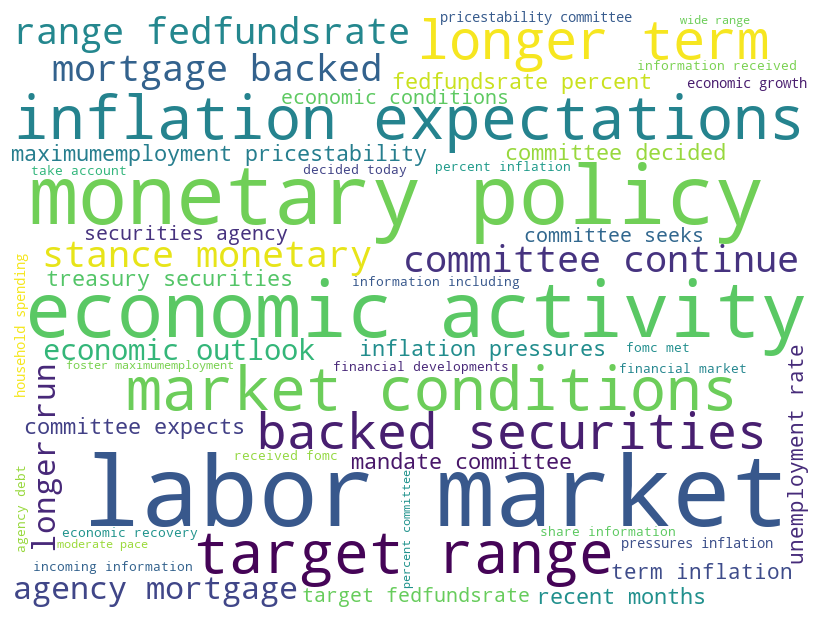

In [45]:
from wordcloud import WordCloud, STOPWORDS
# 合并所有文档的内容
all_text = ' '.join(Data['content'])

# 创建词云对象
wordcloud = WordCloud(width = 800, height = 600, 
                background_color ='white', 
                stopwords = set(STOPWORDS), 
                min_font_size = 10,
                max_words = 50).generate(all_text)

# 显示生成的词云
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()